### **LSI Topic Modeling**
### Scrape .pdf files
We only need to do this one time to download the files into the folder you're working in.

In [27]:
from bs4 import BeautifulSoup as bs
import requests

DOMAIN = "https://papers.xtremepape.rs/"
URL = "https://papers.xtremepape.rs/index.php?dirpath=./CAIE/IGCSE/Geography+%280460%29/&order=1"
FILETYPE = ".pdf"

def get_soup(url):
    return bs(requests.get(url).text, 'html.parser')

for link in get_soup(URL).find_all('a'):
    file_link = link.get('href')
    if file_link.startswith('CAIE/IGCSE') and FILETYPE in file_link and "_qp_2" in file_link:
        print(file_link)
        try:
            with open(link.text, 'wb') as file:
                response = requests.get(DOMAIN + file_link)
                file.write(response.content)
        except Exception as e:
            print("Error downloading file:", e)
            continue


CAIE/IGCSE/Geography (0460)/0460_w21_qp_23.pdf
CAIE/IGCSE/Geography (0460)/0460_w21_qp_22.pdf
CAIE/IGCSE/Geography (0460)/0460_w21_qp_21.pdf
CAIE/IGCSE/Geography (0460)/0460_w20_qp_23.pdf
CAIE/IGCSE/Geography (0460)/0460_w20_qp_22.pdf
CAIE/IGCSE/Geography (0460)/0460_w20_qp_21.pdf
CAIE/IGCSE/Geography (0460)/0460_w19_qp_23.pdf
CAIE/IGCSE/Geography (0460)/0460_w19_qp_22.pdf
CAIE/IGCSE/Geography (0460)/0460_w19_qp_21.pdf
CAIE/IGCSE/Geography (0460)/0460_w18_qp_23.pdf
CAIE/IGCSE/Geography (0460)/0460_w18_qp_22.pdf
CAIE/IGCSE/Geography (0460)/0460_w18_qp_21.pdf
CAIE/IGCSE/Geography (0460)/0460_w17_qp_23.pdf
CAIE/IGCSE/Geography (0460)/0460_w17_qp_22.pdf
CAIE/IGCSE/Geography (0460)/0460_w17_qp_21.pdf
CAIE/IGCSE/Geography (0460)/0460_w16_qp_23.pdf
CAIE/IGCSE/Geography (0460)/0460_w16_qp_22.pdf
CAIE/IGCSE/Geography (0460)/0460_w16_qp_21.pdf
CAIE/IGCSE/Geography (0460)/0460_w15_qp_23.pdf
CAIE/IGCSE/Geography (0460)/0460_w15_qp_22.pdf
CAIE/IGCSE/Geography (0460)/0460_w15_qp_21.pdf
CAIE/IGCSE/Ge

### Import Data

In [3]:
import os
import re

import pandas as pd
import pdfplumber
from collections import namedtuple

import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Leila\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Leila\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Leila\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
Line = namedtuple('Line', 'Paper_ID Question_ID Question_Type Question_Text Token_Text Word_Count')
# file = '0460_w21_qp_22.pdf'

### Pre-processing

In [5]:
total_check = 0
skip_lines = True
concatenate = True
questionNo = 1

concatenated_lines = []

data = []

ignore_patterns = [
    r'^\d+\s*[A-Z]+\s*\d+/\d+/\d+',  # Lines with exam details
    r'^\d+\s*(BLANK PAGE|TURN OVER|Additional Pages)',  # Lines indicating blank pages or page turns
    r'^\[Total:\s*\d+\]$',  # Lines starting with total marks
    r'^© UCLES \d+\s*$',  # Lines starting with copyright information
    r'^\.{3,}',  # Lines starting with three or more dots
    r'\.{10,}', # Lines that contain three or more dots
    r'cid', # Lines that contain 'cid'
    r'© UCLES', # Lines that contain '© UCLES'
    r'^\d+( \d+)*$' # Lines that contain digits and spaces
]

current_dir = os.getcwd()

files = [f for f in os.listdir(current_dir) if f.endswith('.pdf')]

for file in files:
    print(file)
    lines = []
    file_path = os.path.join(current_dir, file)
    with pdfplumber.open(file_path) as pdf:
        Paper_ID = file
        for page in pdf.pages:
            text = page.extract_text()
            for line in text.split('\n'):

                if any(re.search(pattern, line) for pattern in ignore_patterns):
                    # print(line)
                    continue
                elif len(line.strip()) <= 5:
                    continue
                elif 'Additional Pages' in line:
                    skip_lines = True
                    continue
                elif line.startswith('*') and line.endswith('*'):
                    skip_lines = False
                    continue
                elif skip_lines:
                    continue
                else:
                    lines.append(line.strip())

    concatenated_line = ''

    for line in lines:
        if line.startswith('(') == False and not re.search(r'^\d(\d\s| )', line):
            concatenated_line = concatenated_line + line + ' '
        else:
            if concatenated_line != "":
                concatenated_lines.append(concatenated_line.strip())
                
                if concatenated_line.startswith('('):
                    Question_Type = 'SUB'
                    Question_ID = re.search(r'^\((.*?)\)', concatenated_line).group(0)
                elif re.search(r'^\d(\d\s| )', concatenated_line):
                    Question_Type = 'MAIN'
                    Question_ID = re.search(r'^\d(\d\s| )', concatenated_line).group(0)
                    # Question_Text = re.search(r'^\((.*?)\)', line).group(2)

                Question_Text = concatenated_line.replace(str(Question_ID), "")
                Token_Question_Text = word_tokenize(Question_Text)
                tags = pos_tag(Token_Question_Text)
                filtered_words = [word for word in Token_Question_Text if (len(word) > 1) and word.lower() not in stopwords.words('english')]
                # filtered_nouns = [word for word, pos in tags if (pos == 'NN' or pos == 'NNS') and (len(word) > 1) and word.lower() not in stopwords.words('english')]
                # Token_Text = ' '.join(filtered_nouns)
                Token_Text = ' '.join(filtered_words)
                Word_Count = len(Question_Text)
                data.append(Line(Paper_ID, Question_ID, Question_Type, Question_Text, Token_Text, Word_Count))
                # print(concatenated_line)
            concatenated_line = line + ' '
        
print(concatenated_lines)


0460_m17_qp_22.pdf
0460_m18_qp_22.pdf
0460_m19_qp_22.pdf
0460_m20_qp_22.pdf
0460_m21_qp_22.pdf
0460_m22_qp_22.pdf
0460_s14_qp_21.pdf
0460_s14_qp_22.pdf
0460_s14_qp_23.pdf
0460_s15_qp_21.pdf
0460_s15_qp_22.pdf
0460_s15_qp_23.pdf
0460_s16_qp_21.pdf
0460_s16_qp_22.pdf
0460_s16_qp_23.pdf
0460_s18_qp_21.pdf
0460_s18_qp_22.pdf
0460_s18_qp_23.pdf
0460_s19_qp_21.pdf
0460_s19_qp_22.pdf
0460_s19_qp_23.pdf
0460_s20_qp_21.pdf
0460_s20_qp_22.pdf
0460_s20_qp_23.pdf
0460_s21_qp_21.pdf
0460_s21_qp_22.pdf
0460_s21_qp_23.pdf
0460_s22_qp_21.pdf
0460_s22_qp_22.pdf
0460_s22_qp_23.pdf
0460_w14_qp_21.pdf
0460_w14_qp_22.pdf
0460_w14_qp_23.pdf
0460_w15_qp_21.pdf
0460_w15_qp_22.pdf
0460_w15_qp_23.pdf
0460_w16_qp_21.pdf
0460_w16_qp_22.pdf
0460_w16_qp_23.pdf
0460_w17_qp_21.pdf
0460_w17_qp_22.pdf
0460_w17_qp_23.pdf
0460_w18_qp_21.pdf
0460_w18_qp_22.pdf
0460_w18_qp_23.pdf
0460_w19_qp_21.pdf
0460_w19_qp_22.pdf
0460_w19_qp_23.pdf
0460_w20_qp_21.pdf
0460_w20_qp_22.pdf
0460_w20_qp_23.pdf
0460_w21_qp_21.pdf
0460_w21_qp_

### Basic Visualization

In [6]:
df = pd.DataFrame(data)
df.head(200)

,Paper_ID,Question_ID,Question_Type,Question_Text,Token_Text,Word_Count
0,0460_m17_qp_22.pdf,1,MAIN,"Study the map extract for Ballyvaghan, Ireland...",Study map extract Ballyvaghan Ireland scale 1:...,71
1,0460_m17_qp_22.pdf,(a),SUB,The map has blue grid lines which make square...,map blue grid lines make squares area land one...,126
2,0460_m17_qp_22.pdf,10,MAIN,km2,km2,4
3,0460_m17_qp_22.pdf,20,MAIN,km2,km2,4
4,0460_m17_qp_22.pdf,50,MAIN,km2 100 km2,km2 100 km2,12
...,...,...,...,...,...,...
195,0460_m21_qp_22.pdf,(iii),SUB,land use at C,land use,15
196,0460_m21_qp_22.pdf,(iv),SUB,feature D,feature,11
197,0460_m21_qp_22.pdf,(v),SUB,the height above sea level of the spot height...,height sea level spot height,53
198,0460_m21_qp_22.pdf,(b),SUB,A person travels on the footpath from the nor...,person travels footpath north river outside Co...,160


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2655 entries, 0 to 2654
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Paper_ID       2655 non-null   object
 1   Question_ID    2655 non-null   object
 2   Question_Type  2655 non-null   object
 3   Question_Text  2655 non-null   object
 4   Token_Text     2655 non-null   object
 5   Word_Count     2655 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 124.6+ KB


In [8]:
res = df.Token_Text.str.split(expand=True).stack().value_counts()
print(res.head(30))

Fig            1700
map             438
shows           427
shown           410
extract         331
population      305
Using           300
area            278
one             252
answer          241
Table           226
two             225
Describe        214
river           213
Tick            213
Study           213
features        185
information     171
settlement      156
2.1             156
road            155
feature         155
following       150
Insert          145
areas           142
south           141
north           137
use             136
metres          134
5.1             129
Name: count, dtype: int64


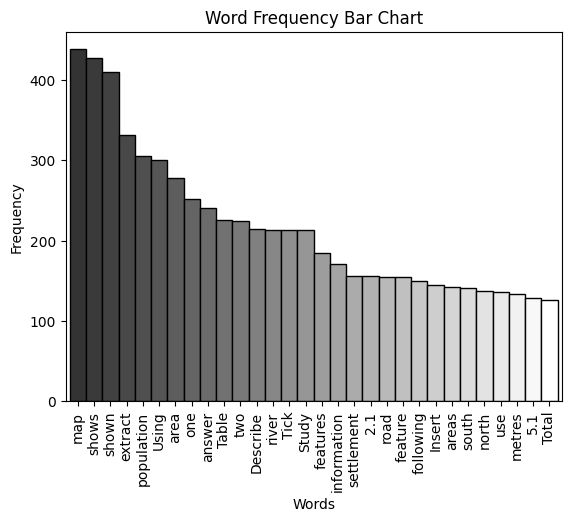

In [9]:
import matplotlib.pyplot as plt
import numpy as np

res.iloc[1:31].plot(kind='bar', color=plt.cm.gray(np.linspace(0.2, 1, 30)), edgecolor='black', width=1)

plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Bar Chart')

plt.show()

In [10]:
# df.to_csv('scrape.csv', index=True)
print(data)
print(df['Token_Text'].str.split().tolist())

[Line(Paper_ID='0460_m17_qp_22.pdf', Question_ID='1 ', Question_Type='MAIN', Question_Text='Study the map extract for Ballyvaghan, Ireland. The scale is 1:50 000. ', Token_Text='Study map extract Ballyvaghan Ireland scale 1:50 000', Word_Count=71), Line(Paper_ID='0460_m17_qp_22.pdf', Question_ID='(a)', Question_Type='SUB', Question_Text=' The map has blue grid lines which make squares. What area of land does one grid square show? Tick one answer below. Tick (3) ', Token_Text='map blue grid lines make squares area land one grid square show Tick one answer Tick', Word_Count=126), Line(Paper_ID='0460_m17_qp_22.pdf', Question_ID='10 ', Question_Type='MAIN', Question_Text='km2 ', Token_Text='km2', Word_Count=4), Line(Paper_ID='0460_m17_qp_22.pdf', Question_ID='20 ', Question_Type='MAIN', Question_Text='km2 ', Token_Text='km2', Word_Count=4), Line(Paper_ID='0460_m17_qp_22.pdf', Question_ID='50 ', Question_Type='MAIN', Question_Text='km2 100 km2 ', Token_Text='km2 100 km2', Word_Count=12), Li

### Bi-gram Phrase Model

In [11]:
import gensim

word_list = df['Token_Text'].str.split().tolist()
print(word_list[0])
print(word_list)
bigram = gensim.models.Phrases(word_list, min_count=20, threshold=10) # higher threshold fewer phrases.
bigram_model = gensim.models.phrases.Phraser(bigram)

print(bigram_model[word_list[0]])
# set1 = set(word_list[0])
# set2 = set(bigram_model[word_list[0]])
# diff_in_list1 = set1 - set2
# print(diff_in_list1)

['Study', 'map', 'extract', 'Ballyvaghan', 'Ireland', 'scale', '1:50', '000']
[['Study', 'map', 'extract', 'Ballyvaghan', 'Ireland', 'scale', '1:50', '000'], ['map', 'blue', 'grid', 'lines', 'make', 'squares', 'area', 'land', 'one', 'grid', 'square', 'show', 'Tick', 'one', 'answer', 'Tick'], ['km2'], ['km2'], ['km2', '100', 'km2'], ['Height', 'sea', 'level', 'shown', 'contour', 'lines', 'difference', 'height', 'contour', 'lines', 'map', 'Tick', 'one', 'answer', 'Tick'], ['green', 'shading', 'grid', 'square', '2807', 'show'], ['Fig', 'shows', 'features', 'east', 'map', 'extract', 'Study', 'Fig', 'map', 'extract', 'answer', 'questions', 'Fig'], ['Identify', 'feature'], ['Identify', 'type', 'road'], ['Give', 'six-figure', 'grid', 'reference', 'road', 'junction'], ['Give', 'height', 'sea', 'level', 'spot', 'height'], ['Describe', 'gradient', 'road'], ['Fig', 'shows', 'location', 'coastal', 'settlements', 'Ballyvaghan', 'Bealaclugga', 'BBeeaallaacclluuggggaa', 'BBaallllyyvvaagghhaann', 'Fig

In [12]:
norm_corpus_bigrams = [bigram_model[q] for q in word_list]

dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
print('Total Vocabulary Size:', len(dictionary))
print('Sample word to number mappings:', list(dictionary.items())[:30])
dictionary.filter_extremes(no_below=9)
print('Total Vocabulary Size:', len(dictionary))
print('Probed sample word to number mappings:', list(dictionary.items())[:30])

Total Vocabulary Size: 4892
Sample word to number mappings: [(0, '000'), (1, 'Ballyvaghan'), (2, 'Ireland'), (3, 'Study'), (4, 'map_extract'), (5, 'scale_1:50'), (6, 'Tick'), (7, 'Tick_one'), (8, 'answer'), (9, 'area'), (10, 'blue'), (11, 'grid'), (12, 'land'), (13, 'lines'), (14, 'make'), (15, 'map'), (16, 'one'), (17, 'show'), (18, 'square'), (19, 'squares'), (20, 'km2'), (21, '100'), (22, 'Height'), (23, 'contour'), (24, 'difference'), (25, 'height'), (26, 'sea_level'), (27, 'shown'), (28, '2807'), (29, 'green')]
Total Vocabulary Size: 641
Probed sample word to number mappings: [(0, '000'), (1, 'Ireland'), (2, 'Study'), (3, 'map_extract'), (4, 'scale_1:50'), (5, 'Tick'), (6, 'Tick_one'), (7, 'answer'), (8, 'area'), (9, 'blue'), (10, 'grid'), (11, 'land'), (12, 'map'), (13, 'one'), (14, 'show'), (15, 'square'), (16, 'squares'), (17, 'km2'), (18, '100'), (19, 'contour'), (20, 'difference'), (21, 'height'), (22, 'sea_level'), (23, 'shown'), (24, 'Fig'), (25, 'answer_questions'), (26, '

### Latent Semantic Indexing (LSI)

In [13]:
corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print([(dictionary[idx] , freq) for idx, freq in corpus[1][:50]])
print('Total number of papers:', len(corpus))

[('Tick', 1), ('Tick_one', 1), ('answer', 1), ('area', 1), ('blue', 1), ('grid', 2), ('land', 1), ('map', 1), ('one', 1), ('show', 1), ('square', 1), ('squares', 1)]
Total number of papers: 2655


In [15]:
TOPIC_NO = 30
lsi_bow = gensim.models.LsiModel(corpus, id2word=dictionary, num_topics=TOPIC_NO, onepass=True, chunksize=2655, power_iters=1000)

for topic_id, topic in lsi_bow.print_topics(num_topics=30, num_words=10):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.854*"Fig" + 0.234*"shows" + 0.168*"shown" + 0.141*"map_extract" + 0.136*"area" + 0.105*"Study" + 0.100*"population" + 0.091*"features" + 0.089*"areas" + 0.084*"Using"

Topic #2:
-0.302*"number" + -0.267*"use" + -0.245*"Insert" + -0.244*"question" + -0.202*"answer" + -0.189*"paper" + -0.188*"Write" + -0.180*"end" + -0.162*"diagrams" + -0.145*"Question_Paper"

Topic #3:
-0.560*"map_extract" + -0.457*"Fig_1.1" + -0.362*"features" + 0.253*"Fig" + -0.198*"Study" + -0.152*"answer_questions" + -0.147*"identify_following" + 0.145*"population" + -0.144*"shown" + -0.138*"Using"

Topic #4:
0.606*"river" + 0.304*"two" + 0.287*"areas" + 0.220*"Tick" + 0.206*"area" + -0.190*"Fig_1.1" + 0.170*"metres" + 0.164*"table" + -0.148*"map_extract" + 0.131*"boxes"

Topic #5:
0.611*"population" + 0.418*"Table" + 0.269*"2.1" + -0.216*"Fig" + 0.149*"per" + -0.147*"area" + 0.143*"river" + 0.135*"countries" + 0.131*"rate" + 0.126*"Fig_1.1"

Topic #6:
-0.607*"river" + 0.424*"areas" + 0.329*"two" + 0.198

### Interpretation
Different directions of each topic means different angles of the topic, similar to branches.
> **e.g.** *Topic #4: The topic is rivers, areas, and measurements. It could further discuss roads and electricity.*

In [22]:
# for n in range(TOPIC_NO):
#     print('Topic #'+str(n+1)+':')
#     print('='*50)
#     d1 = []
#     d2 = []
#     for term, wt in lsi_bow.show_topic(n, topn=20):
#         if wt >= 0:
#             d1.append((term, round(wt, 3)))
#         else:
#             d2.append((term, round(wt, 3)))

#     print('Direction 1:', d1)
#     print('-'*50)
#     print('Direction 2:', d2)
#     print('-'*50)
#     print()

for n in range(TOPIC_NO):
    print('Topic', n)

    d1 = []
    d2 = []

    for term, wt in lsi_bow.show_topic(n, topn=20):
        if wt >= 0:
            d1.append((term, round(wt, 3)))
        else:
            d2.append((term, round(wt, 3)))

    if d1:
        print('Direction 1:', ' '.join([f'{term}' for term, wt in d1]))
    else:
        print('Direction 1:')


    if d2:
        print('Direction 2:', ' '.join([f'{term}' for term, wt in d2]))
    else:
        print('Direction 2:')

    print()


Topic 0
Direction 1: Fig shows shown map_extract area Study population features areas Using two 2.1 answer_questions Table Describe river 4.1 one 5.1 1.3
Direction 2:

Topic 1
Direction 1:
Direction 2: number use Insert question answer paper Write end diagrams Question_Paper Survey_Map Extract pages Question questions provided pen enclosed required Photograph

Topic 2
Direction 1: Fig population 2.1 Table
Direction 2: map_extract Fig_1.1 features Study answer_questions identify_following shown Using river areas shows two settlement Fig_1.2 table around

Topic 3
Direction 1: river two areas Tick area metres table boxes land Fig_1.2 Area correct north one
Direction 2: Fig_1.1 map_extract Fig features Using identify_following

Topic 4
Direction 1: population Table 2.1 per river countries rate Fig_1.1 shows country migration people total percentage change 000 age South
Direction 2: Fig area

Topic 5
Direction 1: areas two area table population Area shows one Complete tick putting land tick